In [1]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

/Users/louis/mambaforge/envs/dlux/lib/python3.10/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
import equinox as eqx
import optax
import functools as ft # used for equinox filtering
import pickle as p

In [3]:
from dLux import *
from helpers import *
from tqdm.notebook import tqdm

from model_layers import toliman_layers
from plotting import plot_batch

In [4]:
plt.figure()
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["text.usetex"] = 'true'
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.dpi'] = 96
# plt.rcParams.keys()

<Figure size 432x288 with 0 Axes>

---

# Create osys

In [5]:
basis = np.load("files/basis.npy")
wavels = 1e-9 * np.linspace(595, 695, 3)

In [6]:
ppf = get_ppf(wavels)
min_fringe = 1
max_fringe = 10

rmin = min_fringe/ppf
rmax = max_fringe/ppf
print(rmin, rmax)

5.239384615384616 52.39384615384616


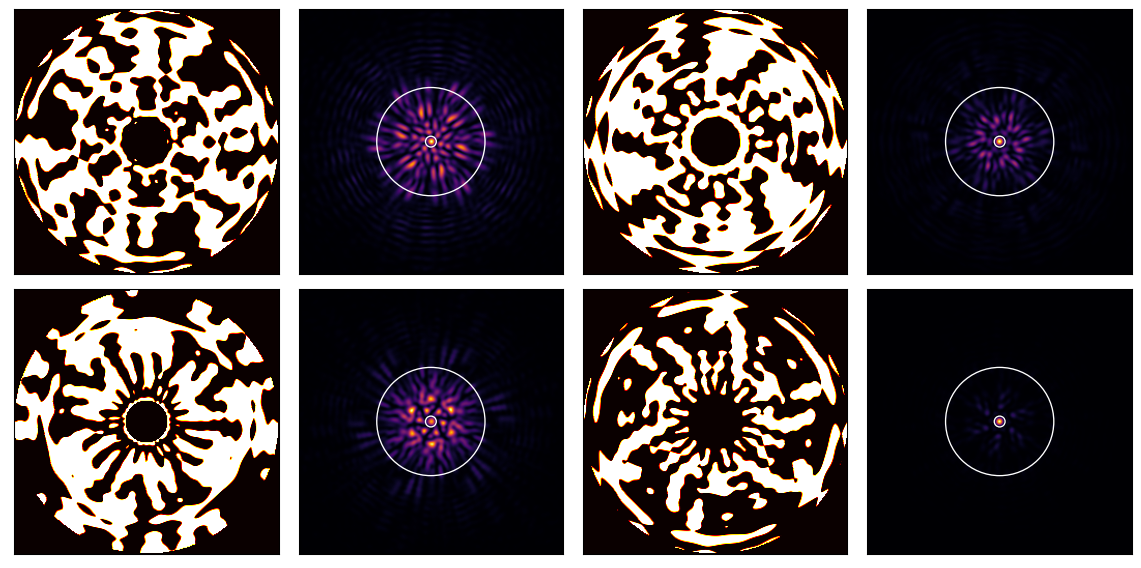

In [7]:
nseeds = 4
osyses = []
for i in range(nseeds):
    onp.random.seed(i)
    coeffs = norm_rand(0, 100, [len(basis)])

    layers = toliman_layers([ApplyBasisCLIMB(basis, coeffs, np.mean(wavels))])    
    osyses.append(OpticalSystem(layers, 
                                wavels=wavels,
                                detector_layers=[ApplyJitter(1)]))
    
plot_batch(osyses, rmin=rmin, rmax=rmax, rmask=True)

In [8]:
# Default values to group 0
filter_spec = jax.tree_map(lambda _: False, osyses)

# Set filtering Tree
for i in range(len(osyses)):
    filter_spec[i] = eqx.tree_at(lambda osys: osys.layers[4].coeffs, filter_spec[i], replace=True)

@eqx.filter_jit
@ft.partial(eqx.filter_value_and_grad, filter_spec=filter_spec)
def loss_func(models, rmin=20, rmax=150, power=0.5):
    loss = 0
    for i in range(len(models)):
        # Get PSF & Gradients and Mask
        psf = models[i]()
        Rmask = get_Rmask(psf.shape[0], rmin, rmax)

        # Calcualte loss
        loss1 = - np.power(Rmask*get_GE(psf), power).sum()
        loss2 = - np.power(Rmask*get_RGE(psf), power).sum()
        loss += loss1 + loss2
    return loss

/Users/louis/mambaforge/envs/dlux/lib/python3.10/site-packages/equinox/grad.py:71: UserWarning: For brevity the `filter_spec` argument has been renamed `arg`
  warnings.warn("For brevity the `filter_spec` argument has been renamed `arg`")


In [9]:
%%time
loss, grads = loss_func(osyses, rmin=rmin, rmax=rmax) # Compile

print("Initial Loss: {}".format(loss))

Initial Loss: -111.12072732849438
CPU times: user 16.6 s, sys: 324 ms, total: 17 s
Wall time: 12.7 s


In [10]:
model = osyses
optim = optax.adam(5e1)
opt_state = optim.init(model)

errors, grads_out, models_out = [], [], []
for i in tqdm(range(100)):
    loss, grads = loss_func(model, rmin=rmin, rmax=rmax)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    models_out.append(model)
    errors.append(loss)
    grads_out.append(grads)
        
    if i<10 or i%10 == 0:
        print("Epoch: {} Loss: {:.3f}".format(i, loss))

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 Loss: -111.121
Epoch: 1 Loss: -140.729
Epoch: 2 Loss: -152.427
Epoch: 3 Loss: -159.012
Epoch: 4 Loss: -162.395
Epoch: 5 Loss: -164.614
Epoch: 6 Loss: -165.839
Epoch: 7 Loss: -167.176
Epoch: 8 Loss: -168.254
Epoch: 9 Loss: -169.175
Epoch: 10 Loss: -169.872
Epoch: 20 Loss: -175.757
Epoch: 30 Loss: -179.445
Epoch: 40 Loss: -181.914
Epoch: 50 Loss: -183.691
Epoch: 60 Loss: -185.592
Epoch: 70 Loss: -186.713
Epoch: 80 Loss: -187.470
Epoch: 90 Loss: -187.845


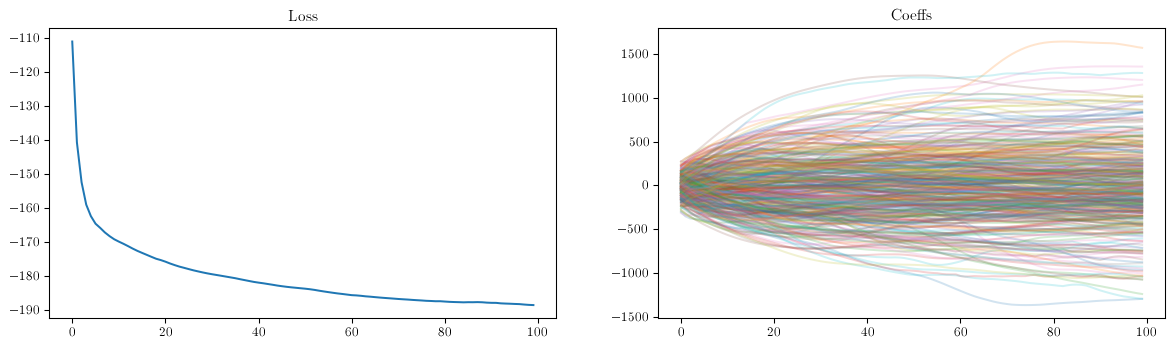

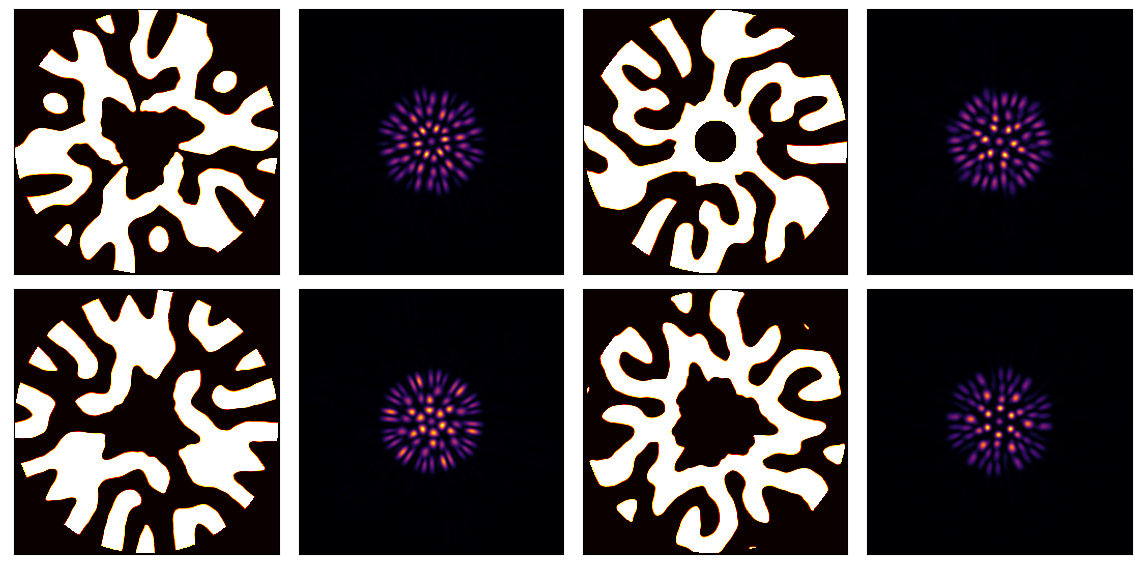

In [11]:
coeffs_out = np.array([[model[i].layers[4].coeffs for i in range(len(model))] for model in models_out])

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(np.array(errors))
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.title("Coeffs")
for i in range(len(models_out[0])):
    plt.plot(coeffs_out[:, i], alpha=0.2)
plt.show()

plot_batch(models_out[-1], ncols=4)

In [12]:
# Save mask
binary_mask = models_out[-1][1].layers[-2].get_binary_phase()
np.save("files/binary_mask", binary_mask)

# plt.imshow(binary_mask)
# plt.colorbar()
# plt.show()

In [13]:
nframes = 50
idxs = ((len(models_out)-1)*np.linspace(0, 1, nframes)**2).astype(int)

# plt.scatter(np.arange(len(idxs)), idxs)
# plt.show()

filenames = []
for i in tqdm(idxs):
    filename = 'gif_figs/rge_{}.png'.format(i)
    plot_batch(models_out[i], filename=filename, dpi=72)
    filenames.append(filename)
    
    nhold = 20
filenames_out = []
for i in range(nhold):
    filenames_out.append(filenames[0])
    
filenames_out += filenames
for i in range(2*nhold):
    filenames_out.append(filenames[-1])

  0%|          | 0/50 [00:00<?, ?it/s]

In [14]:
import imageio
kwargs = { 'duration': 0.075 }
with imageio.get_writer('figures/rge.gif', mode='I', **kwargs) as writer:
    for filename in tqdm(filenames_out):
        image = imageio.imread(filename)
        writer.append_data(image)

  0%|          | 0/110 [00:00<?, ?it/s]

/var/folders/28/6s47s91d14ldjdrljs4d1hxw0000gn/T/ipykernel_86276/1747967652.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
